In [12]:
import sys
sys.path.insert(0, '/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/tools')
sys.path.insert(0, '/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/test.py')

In [29]:

import os
# Turn off warnings and errors due to TF libraries
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import time
import datetime
import csv
from random import shuffle
import tensorflow as tf
# import internal scripts
#from tools.tools import *
from tools import *
from test import test
import configs
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np

import yaml

In [16]:
config = yaml.safe_load(open('/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/configs/CGNN_iter1.yaml'))

In [17]:
from qnetworks.CGNN import GNN

GNN.config = config

In [45]:
def load_params(model, log_path):
    #n_layers = len(glob.glob('{}*{}*'.format(log_path,'parameters')))
    n_layers=10
    
    if n_layers > 0:
        for idx in range(n_layers):
            param_file = log_path + 'log_parameters_%d'%(idx) + '.csv'
            val_file   = log_path + 'log_validation.csv'
            # read the last line of the parameter file
            with open(param_file, 'r') as f:
                reader = csv.reader(f, delimiter=',')  
                params = np.array(list(reader)).astype(float)[-1]
            with open(val_file, 'r') as f:
                reader = csv.reader(f, delimiter=',')  
                val = np.array(list(reader))
            last_epoch = val.shape[0]-2
            # make sure they have the same shape
            params = np.resize(params, model.trainable_variables[idx].shape)
            # Load the parameter to corresponding layer
            model.trainable_variables[idx].assign(params)
            
        return model, last_epoch
    else:
        raise ValueError('No parameter log found!')

In [46]:
model = GNN()

In [47]:
#model, epoch_start = load_params(model, config['log_dir'])
model, epoch_start = load_params(model,'/Users/lucascurtin/Desktop/SSH_LOGS/run2/')

In [49]:
valid_data = get_dataset('/Users/lucascurtin/Desktop/QGNN Repos/HepTrkX-quantum/data/tuysuz_100_events/valid', config['n_valid'])
n_test=config['n_valid']


In [50]:

n_test=5


In [51]:
#config = load_config(parse_args())
tools.config = config

In [52]:
for n in range(5):

        X, Ri, Ro, y = valid_data[n]

        if n == 0:
            preds = model([map2angle(X), Ri, Ro])
            labels = y
        else:	
            out = model([map2angle(X), Ri, Ro])
            preds  = tf.concat([preds, out], axis=0)
            labels = tf.concat([labels, y], axis=0)

In [53]:
fpr, tpr, thresholds = metrics.roc_curve(labels,preds,pos_label=1 )
roc_auc=roc_auc_score(labels, preds)

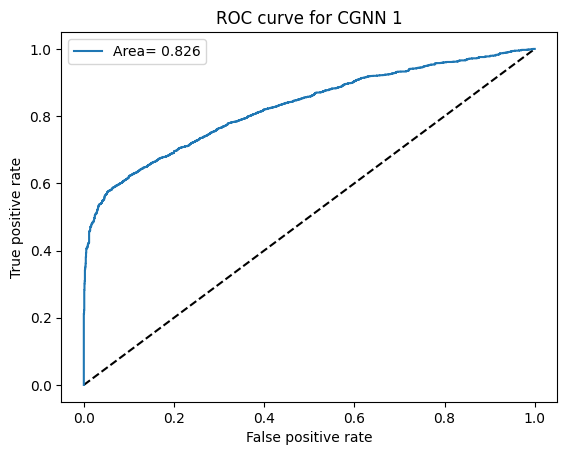

In [54]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area= {:.3f}'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for CGNN 1')
plt.legend(loc='best')
plt.show()

#### Now going to try and develop confusion matrices.

In [55]:
preds_np=preds.numpy() #This turns our preds into an array rather than a tf tensor
labels_np=labels.numpy()

In [56]:
preds_5=preds_np
preds_5[preds_5<0.5]=0

preds_5[preds_5>0.5]=1

In [57]:
cm_result = metrics.confusion_matrix(labels_np,preds_5)

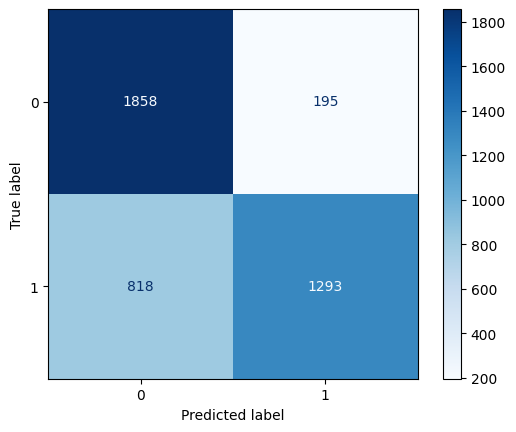

In [58]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_result)

print(disp)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [59]:
tn=cm_result[0,0]
fp=cm_result[0,1]
tp=cm_result[1,1]
fn=cm_result[1,0]

n_0=tn + fp
n_1=tp+ fn

print('The number of 0 data points are:',n_0)
print('The number of 1 data points are:',n_1)
print('The imbalance in our classes is:', n_1-n_0)

The number of 0 data points are: 2053
The number of 1 data points are: 2111
The imbalance in our classes is: 58


#### Now going to try and develop histograms.

In [60]:
# So we would like to split our predictions into predictions made on 0 labels and 1 labels

labels_0=np.where(labels.numpy() == 0)[0]

preds_0=[] #The predictions on all our 0 labels

for i in range(len(labels_0)):

    index=labels_0[i] # grab our index
    guess=preds.numpy()[index] # find our prediction at the corresponding index
    preds_0.append(guess[0])
    



In [61]:
# So we would like to split our predictions into predictions made on 0 labels and 1 labels

labels_1=np.where(labels.numpy() == 1)[0]

preds_1=[] #The predictions on all our 1 labels

for i in range(len(labels_1)):


    index=labels_1[i] # grab our index
    guess=preds.numpy()[index] # find our prediction at the corresponding index
    preds_1.append(guess[0])
    



In [62]:
preds.numpy()

array([[0.53761137],
       [0.5378214 ],
       [0.99575514],
       ...,
       [0.97095686],
       [0.9983448 ],
       [0.99838334]], dtype=float32)

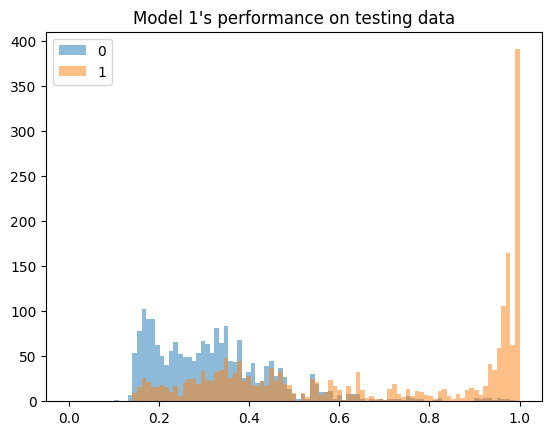

In [63]:
bins = np.linspace(0, 1, 100)

plt.hist(preds_0, bins, alpha=0.5, label='0')
plt.hist(preds_1, bins, alpha=0.5, label='1')
plt.legend(loc='best')
plt.title("Model 1's performance on testing data")
plt.show()